# implement line sweeps of params
- all params fixed expcet one, which is swept over range
- specifically looking at test accuracy as a function of one param


In [1]:
from matplotlib import pyplot as plt
from scipy.special import softmax
from itertools import product
import numpy as np
from utils import *
from model import *
import time
import seaborn as sns
sns.set_context('talk')

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## timestamp and dir for saving
tstamp = time.perf_counter_ns()
import os
os.mkdir('figures/scratch_folders/%i'%tstamp)

In [3]:
## default params
expargs = {
  'condition':'blocked',
  'n_train':160,
  'n_test':40
}
schargs = {
    'concentration':311,
    'stickiness_wi':680,
    'stickiness_bt':470, # 100
    'sparsity':0.99,
    'pvar': 0,
    'lrate':1,
    'lratep':1,
    'decay_rate':1,
} 
semargs = {
  'beta2':False
}
args = {
    'sem':semargs,
    'sch':schargs,
    'exp':expargs
}
param_str = "-".join(["%s_%.3f"%(i,j) for i,j in schargs.items()])
param_str += "-"+"-".join(["%s_%.3f"%(i,j) for i,j in semargs.items()])
param_str

'concentration_311.000-stickiness_wi_680.000-stickiness_bt_470.000-sparsity_0.990-pvar_0.000-lrate_1.000-lratep_1.000-decay_rate_1.000-beta2_0.000'

In [4]:
# p_name = 'concentration' # 
# p_vals = np.arange(310,312,0.25)

# p_name = 'stickiness_wi' # 5000
# p_vals = np.arange(500,600,5)

# p_name = 'stickiness_bt' # 100
# p_vals = np.arange(440,550,5)

# p_name = 'sparsity' # 0.08
# p_vals = np.arange(0.5,1.5,0.05)

p_name = 'pvar' # 0
p_vals = np.arange(0,2,0.2)

# p_name = 'lrate' # 1
# p_vals = np.arange(0.5,1.01,0.05)

# p_name = 'lratep' # 1
# p_vals = np.arange(0.8,1.01,0.02)

# p_name = 'decay_rate' # 1
# p_vals = np.arange(0.95,1.000001,0.005)

p_name,p_vals

('pvar', array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8]))

### main

In [5]:
def pltsave_macc(macc,schargs=None,labL=['B','I','E','M','L'],close=True):
  """ 
  save accuracy of individual parameter setting 
  used in paramsearch loops
  """
  plt.figure(figsize=(10,4))
  ax=plt.gca()
  for idx in range(len(macc)):
    ax.plot(macc[idx],label=labL[idx])
  ax.axhline(0.5,c='k')
  plt.legend()
  param_str = "-".join(["%s_%.3f"%(i,j) for i,j in schargs.items()])
  plt.savefig('figures/scratch_folders/%i/acc-%s.jpg'%(tstamp,param_str))
  if close:
    plt.close('all')
  return None


In [6]:
ns = 50
dfL = []
condL = ['blocked','interleaved','early','middle','late']
for idx,p_val in enumerate(p_vals):
  print(idx/len(p_vals))
  
  args['sch'][p_name] = p_val  
  exp_batch_data = run_batch_exp_curr(ns,args,condL)
  ## acc
  batch_acc = unpack_acc(exp_batch_data) # curr,seeds,trials
  mean_acc = batch_acc.mean(1)
  test_acc = mean_acc[:,-40:].mean(1) # curr  
  
  ## save traces of EML for each param setting
  pltsave_macc(mean_acc[2:],args['sch'],labL=['E','M','L'])
  
  ## record
  gsD = {
    **schargs,
    **dict(zip(condL,test_acc))
  }
  dfL.append(gsD)
  
gsdf = pd.DataFrame(dfL)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [7]:
gsdf ## test acc dataframe

,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,blocked,interleaved,early,middle,late
0,311,680,470,0.99,0.0,1,1,1,0.930903,0.509411,0.755619,0.600155,0.486251
1,311,680,470,0.99,0.2,1,1,1,0.942293,0.493561,0.778032,0.582136,0.503484
2,311,680,470,0.99,0.4,1,1,1,0.952012,0.494128,0.800510,0.628595,0.497317
3,311,680,470,0.99,0.6,1,1,1,0.965824,0.502066,0.802339,0.570567,0.500821
4,311,680,470,0.99,0.8,1,1,1,0.926869,0.506175,0.802458,0.589768,0.513380
5,311,680,470,0.99,1.0,1,1,1,0.945260,0.511184,0.754580,0.602867,0.504841
6,311,680,470,0.99,1.2,1,1,1,0.950196,0.515364,0.781471,0.577233,0.505322
7,311,680,470,0.99,1.4,1,1,1,0.947709,0.485016,0.773899,0.537512,0.510002
8,311,680,470,0.99,1.6,1,1,1,0.961400,0.502811,0.750109,0.593639,0.502583
9,311,680,470,0.99,1.8,1,1,1,0.891547,0.500478,0.739517,0.542756,0.512775


### plt 

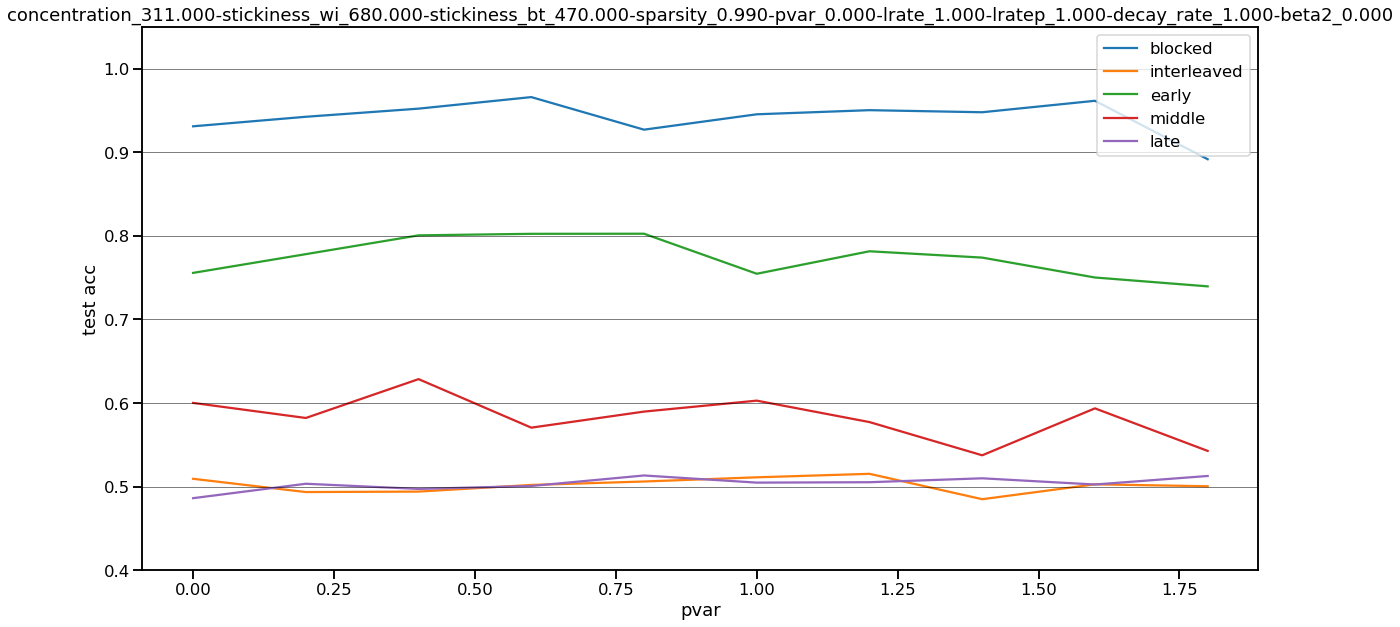

In [8]:
plt.figure(figsize=(20,10))
ax = plt.gca()
gsdf.plot(p_name,condL,ax=ax)
ax.set_ylim(0.4,1.05)
ax.set_ylabel('test acc')
for i in np.arange(0.5,1.01,0.1):
  ax.axhline(i,c='k',lw=0.5)
plt.title(param_str)
plt.savefig('figures/scratch/testacc-sweep_%s-default_%s-t%s.png'%(
  p_name,param_str,tstamp))